In [1]:
%matplotlib inline
import pandas as pd

In [2]:
# u may download data from (https://archive.ics.uci.edu/ml/datasets/Iris).
df = pd.read_csv('iris.data', header=None)

feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
from sklearn.preprocessing import LabelEncoder

X = df[[0,1,2,3]].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

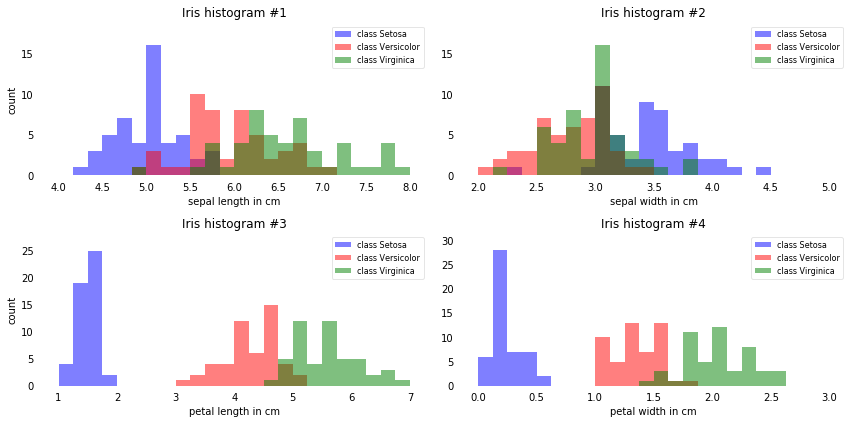

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

In [7]:
# 从上图的结果中可以看出，花瓣的长度和宽度看起来在不同的类别有较强的区分性，因为这2个特征的直方图中，不同的类别的样本较为分散。
# 因此在实际应用中，我们对特征进行降维，除了使用类似于LDA的特征投影方法（或者叫extraction），特征选择（selection）也是一种较好的方式。
# 像上图这种低纬度的数据集，看一眼直方图我们就可以做出一定的判断。

In [5]:
# step1：计算D维特征样本的均值向量
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [ 5.006  3.418  1.464  0.244]

Mean Vector class 2: [ 5.936  2.77   4.26   1.326]

Mean Vector class 3: [ 6.588  2.974  5.552  2.026]



In [6]:
# step2: 计算散度矩阵

# 计算类内散度矩阵：Sw
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

('within-class Scatter Matrix:\n', array([[ 38.9562,  13.683 ,  24.614 ,   5.6556],
       [ 13.683 ,  17.035 ,   8.12  ,   4.9132],
       [ 24.614 ,   8.12  ,  27.22  ,   6.2536],
       [  5.6556,   4.9132,   6.2536,   6.1756]]))


In [7]:
# 计算类间三度矩阵:Sb
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

('between-class Scatter Matrix:\n', array([[  63.2121,  -19.534 ,  165.1647,   71.3631],
       [ -19.534 ,   10.9776,  -56.0552,  -22.4924],
       [ 165.1647,  -56.0552,  436.6437,  186.9081],
       [  71.3631,  -22.4924,  186.9081,   80.6041]]))


In [8]:
# step3：求解S−1WSB的特征值问题：
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.121 ]
 [-0.3294]
 [-0.3854]
 [ 0.6947]]
Eigenvalue 3: -9.06e-16

Eigenvector 4: 
[[ 0.121 ]
 [-0.3294]
 [-0.3854]
 [ 0.6947]]
Eigenvalue 4: -9.06e-16


In [9]:
print eig_vals, eig_vecs

[  3.2272e+01 +0.0000e+00j   2.7757e-01 +0.0000e+00j
  -9.0643e-16 +4.0117e-15j  -9.0643e-16 -4.0117e-15j] [[-0.2049+0.j     -0.0090+0.j      0.1210-0.4213j  0.1210+0.4213j]
 [-0.3871+0.j     -0.5890+0.j     -0.3294+0.186j  -0.3294-0.186j ]
 [ 0.5465+0.j      0.2543+0.j     -0.3854+0.1833j -0.3854-0.1833j]
 [ 0.7138+0.j     -0.7670+0.j      0.6947+0.j      0.6947-0.j    ]]


In [10]:
# step4：选择新的特征空间
# 先将特征向量按照特征值的大小降序排列，线代中告诉我我们，矩阵乘法可以看做一种线性变换，而特征向量和特征值代表了变换后的方向以及该方向上的
# 缩放比例，因此特征值越大，说明这个方向在变换中越显著，也就是信息量最大。因此我们需要抛弃的是特征值较小的方向，因此我们只需要选取前topk个特征值
# 对应的特征向量，就得到了映射矩阵W

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print (i[0], i[1])

Eigenvalues in decreasing order:

(32.271957799729854, array([-0.2049+0.j, -0.3871+0.j,  0.5465+0.j,  0.7138+0.j]))
(0.27756686384004819, array([-0.0090+0.j, -0.5890+0.j,  0.2543+0.j, -0.7670+0.j]))
(4.1128438341442383e-15, array([ 0.1210-0.4213j, -0.3294+0.186j , -0.3854+0.1833j,  0.6947+0.j    ]))
(4.1128438341442383e-15, array([ 0.1210+0.4213j, -0.3294-0.186j , -0.3854-0.1833j,  0.6947-0.j    ]))


In [11]:
# 从上面的特征值可以看到有2个特征值非常接近0，这2个值之所以接近0，一是代表了他们不包含信息量，第二是因为浮点运算的精确度问题。
# 实际上这2分特征值应该就是0， 因为在LDA中，如果有C类，线性判别式最多只有C-1个，因此对于之前3类的数据集，最多只有2个特征值。
# 由于类间散度矩阵S_B是不同类别C矩阵的和，而C矩阵的秩是1，对于最特殊的完美共线性情况（即所有样本点都在一条直线上），协方差矩阵的秩就会是1，
# 这就导致了只会有一个非0的特征值。
# 我们通过特征值的比例来体现方差的分布：
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [17]:
# 选择K个特征向量作为映射矩阵，这里选了前2个有信息的。
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print 'Matrix W:'
print W.real

Matrix W:
[[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


In [13]:
# step5：将样本投影到新的空间
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

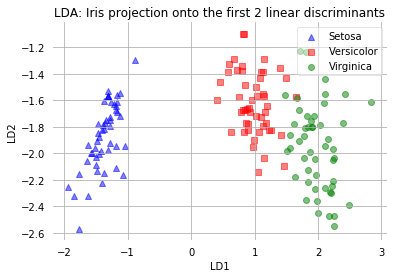

In [14]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()